In [96]:
import netCDF4 as nc
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import xarray as xr
import numpy as np
import scipy
import plotly.express as px
from scipy.stats import mstats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import csv
import fiona
import geopandas
import os
import random
import plotly.graph_objects as go
import contextily as cx
from numpy import log10

# Notebook Summary

This Jupyter notebook is designed to analyze the time of emergence (ToE) for human mortality due to extreme temperatures in the context of climate change. The mortality data used in this analysis is derived from [Carleton et al. (2022)][1], which provides detailed datasets on mortality rates. These datasets are organized by different combinations of Representative Concentration Pathways (RCPs), Shared Socioeconomic Pathways (SSPs), General Circulation Models (GCMs), and Integrated Assessment Models (IAMs). 

In this notebook, we specifically focus on the mortality data for individuals aged 64 and younger. Our goal is to identify the time of emergence, which is defined as the point in time when the signal of climate change-induced mortality becomes statistically distinct from the background variability. This analysis will help us understand the potential future impacts of climate change on human health, particularly for younger populations, under various climate and socioeconomic scenarios.

[1]:https://academic.oup.com/qje/article/137/4/2037/6571943
---


# [Carleton et al. (2022)][1] Data Summary
## Mortality Data

Mortality data are collected independently from 40 countries, covering mortality outcomes for 38% of the global population. This dataset represents a significant increase in coverage compared to previous studies, which typically focus on individual countries or regions, or combine small nonrandom samples from multiple countries. 

- **Spatial and Temporal Coverage**: The data is harmonized into a single multicountry unbalanced panel dataset of age-specific annual mortality rates, categorized into three age groups: < 5, 5–64, and > 64. The unit of observation is the second administrative unit (ADM2), equivalent to a county in the United States, by year.

### Country-specific Data:

- **Brazil**: 228,762 records (ADM2, 1997–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **Chile**: 14,238 records (ADM2, 1997–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **China**: 7,488 records (ADM2, 1991–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **EU**: 13,013 records (NUTS2, 1990–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **France**: 3,744 records (ADM2, 1998–2010), mortality rates for 0–19, 20–64, and > 64 age groups.
- **India**: 12,505 records (ADM2, 1957–2001), mortality rates for all ages.
- **Japan**: 5,076 records (ADM1, 1975–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **Mexico**: 146,835 records (ADM2, 1990–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **United States**: 401,542 records (ADM2, 1968–2010), mortality rates for < 5, 5–64, and > 64 age groups.

## Historical Climate Data:

- **GMFD, V1**: Provided by Sheffield, Goteti, and Wood (2006) - Reanalysis and interpolation, 0.25° temperature and precipitation data from Princeton University.
- **BEST**: Provided by Rohde et al. (2013) - Interpolation, 1° temperature data from Berkeley Earth.
- **UDEL**: Provided by Matsuura and Willmott (2007) - Interpolation, 0.5° precipitation data from the University of Delaware.

### Notes:

- **Mortality Rate**: Reported in units of deaths per 100,000 population. Outliers are winsorized at the 1% level at the high end of the distribution across administrative regions for each country.
- **Covariate Values**: Average values over the years in each country sample.
- **ADM Levels**: ADM2 refers to the second administrative level (e.g., county), and ADM1 refers to the first administrative level (e.g., state). NUTS2 refers to the Nomenclature of Territorial Units for Statistics 2nd level, specific to the European Union.
- **GDP Per Capita**: Values are in constant 2005 dollars purchasing power parity.
- **Temperature Data**: Average daily temperature and the number of days above 28°C are population-weighted using 2010 population values.
- **EU Data**: Covers 33 countries, with most records beginning in 1990.
- **France**: Separated from the rest of the EU due to availability of higher-resolution mortality data.
- **India**: Mortality rates may be understated due to incomplete registration of deaths.

---

[1]:https://academic.oup.com/qje/article/137/4/2037/6571943

## Function: `get_file_path`

The `get_file_path` function is designed to construct and return the file path for specific mortality data files based on the given parameters. This function is essential for managing and accessing the various datasets used in the analysis of human mortality due to extreme temperatures and climate change.

## Parameters:

- `dat_dir` (str): The base directory where the data is stored.
- `rcp` (str): The Representative Concentration Pathway (RCP) scenario.
- `iam` (str): The Integrated Assessment Model (IAM) scenario.
- `ssp` (str): The Shared Socioeconomic Pathway (SSP) scenario.
- `mortality_file` (str): The specific mortality file type needed, which can be 'fn_full', 'fn_inc', or 'fn_none'.

## Functionality:

1. **Data Dictionary**: A dictionary (`data_dict`) maps the `mortality_file` parameter to the corresponding file names:
    - `Full Climate and Income Adpation Scenario: 'fn_full'`: `Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest.nc4`
    - `Full Income Adaptation, no Climate Adpation Scenario: 'fn_inc'`: `Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-incadapt.nc4`
    - `No Climate and no Income Adapation Scenario: 'fn_none'`: `Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4`

2. **File Name Retrieval**: The function retrieves the file name from the dictionary based on the `mortality_file` parameter. If an invalid file name is provided, a `ValueError` is raised.

3. **Path Construction**: The function constructs the file path using `os.path.join`, combining the base directory (`dat_dir`) with the specified `rcp`, 'CCSM4', `iam`, `ssp`, and the retrieved file name.

4. **Return**: The constructed file path is returned.

This function ensures a standardized and error-checked approach to accessing the necessary mortality data files for further analysis.

---

In [2]:
def get_file_path(dat_dir, rcp, iam, ssp, mortality_file):
    data_dict = {
        'fn_full': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest.nc4',
        'fn_inc': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-incadapt.nc4',
        'fn_none': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4',
    }
    
    file_name = data_dict.get(mortality_file, '')
    if not file_name:
        raise ValueError("Invalid file name provided.")

    path = os.path.join(dat_dir, rcp, 'CCSM4', iam, ssp, file_name)
    return path
    

## Function: `get_histclim_file_path`

Similar to the `get_file_path`, the `get_histclim_file_path` function is designed to construct and return the file path for historical climate mortality data files based on the given parameters. This function is crucial for managing and accessing the historical climate datasets required for analyzing human mortality due to extreme temperatures and climate change.

### Parameters:

- `histclim_dat_dir` (str): The base directory where the historical climate data is stored.
- `rcp` (str): The Representative Concentration Pathway (RCP) scenario.
- `iam` (str): The Integrated Assessment Model (IAM) scenario.
- `ssp` (str): The Shared Socioeconomic Pathway (SSP) scenario.
- `histclim_file` (str): The specific historical climate file type needed, which can be 'fn_histclim'.

In [3]:
def get_histclim_file_path(histclim_dat_dir, rcp, iam, ssp, histclim_file):
    histclim_data_dict = {
        'fn_histclim': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-histclim.nc4'
    }
    
    histclim_file_name = histclim_data_dict.get(histclim_file, '')
    if not histclim_file_name:
        raise ValueError("Invalid file name provided.")

    histclim_path = os.path.join(histclim_dat_dir, rcp, 'CCSM4', iam, ssp, histclim_file_name)
    return histclim_path
    

## Function: `get_econ_file_path`

Similar to `get_file_path` and `get_histclim_file_path`, the `get_econ_file_path` function is designed to construct and return the file path for economic data files based on the given parameters. This function is important for managing and accessing the socioeconomic datasets required for the analysis of human mortality due to extreme temperatures and climate change.

### Parameters:

- `econ_dat_dir` (str): The base directory where the economic data is stored.
- `econ_file` (str): The specific socioeconomic pathway file needed, which can be 'SSP1', 'SSP2', 'SSP3', 'SSP4', or 'SSP5'.

In [4]:
def get_econ_file_path(econ_dat_dir, econ_file):
    data_dict = {
        'SSP1': 'SSP1.nc4',
        'SSP2': 'SSP2.nc4',
        'SSP3': 'SSP3.nc4',
        'SSP4': 'SSP4.nc4',
        'SSP5': 'SSP5.nc4'
    }
    
    econ_file_name = data_dict.get(econ_file, '')
    if not econ_file_name:
        raise ValueError("Invalid file name provided.")

    econ_path = os.path.join(econ_dat_dir, econ_file_name)
    return econ_path

## Data Directories and Scenario Definitions

In this section, we define the data directories and the available scenarios for the analysis of human mortality due to extreme temperatures and climate change. These definitions are for organizing and accessing the necessary datasets for the study.

### Data Directories:

- `dat_dir`: This directory contains the main mortality projection data files.

  /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single
  ```

- `econ_dat_dir`: This directory contains the economic variables data files.
  
  /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/
  ```

- `histclim_dat_dir`: This directory contains the historical climate data files.
            /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single
  ```

### Available Scenarios:

- **Representative Concentration Pathways (RCPs)**: These pathways describe different greenhouse gas concentration trajectories.
  - `'45'`: RCP4.5, a stabilization scenario where radiative forcing stabilizes at 4.5 W/m².
  - `'85'`: RCP8.5, a high greenhouse gas emissions scenario.

- **Integrated Assessment Models (IAMs)**: These models represent different socioeconomic pathways and their associated uncertainty ranges.
  - `'low'`: This represents a scenario with lower socioeconomic growth, which could imply slower economic development, lower population growth, and potentially lower emissions if combined with effective climate policies.
  - `'high'`: This represents a scenario with higher socioeconomic growth, implying rapid economic development, higher population growth, and potentially higher emissions if not combined with effective climate policies.

- **Shared Socioeconomic Pathways (SSPs)**: These pathways describe different socio-economic futures.
  - `'SSP3'`: Regional Rivalry
  - `'SSP4'`: Inequality
  - `'SSP5'`: Fossil-fueled Development

These directories and scenario definitions will be used throughout the analysis to access and process the relevant data files.

---

In [5]:
# Define data directory
dat_dir = '/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single'
econ_dat_dir = '/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/'
histclim_dat_dir = '/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single'

# Define available RCPs and uncertainty ranges
rcps = ['45', '85']
iams = ['low', 'high']
ssp = ['SSP3','SSP4','SSP5']



## Example Usage

In this section, we demonstrate how to use the previously defined functions to obtain the file paths for mortality, economic, and historical climate data files. These file paths are for accessing the relevant datasets needed for our analysis.

### Parameters (Can be changed based on user input):

- **Mortality File**: `'fn_none'`
- **RCP Scenario**: `'rcp85'`
- **IAM Scenario**: `'low'`
- **SSP Scenario**: `'SSP3'`
- **Economic File**: `'SSP3'`
- **Historical Climate File**: `'fn_histclim'`


## Function Explanation:

- **`get_file_path(dat_dir, rcp, iam, ssp, mortality_file)`**: This function takes the data directory path, RCP, IAM, SSP, and the specific mortality file name as input parameters. It constructs and returns the file path based on these inputs.
- **`get_econ_file_path(econ_dat_dir, econ_file)`**: This function takes the economic data directory path and the specific SSP file name as input parameters. It constructs and returns the file path based on these inputs.
- **`get_histclim_file_path(histclim_dat_dir, rcp, iam, ssp, histclim_file)`**: This function takes the historical climate data directory path, RCP, IAM, SSP, and the specific historical climate file name as input parameters. It constructs and returns the file path based on these inputs.`

---


In [6]:
# Example usage:
mortality_file = 'fn_none'
rcp = 'rcp85'
iam = 'low'
ssp = 'SSP3'
econ_file = 'SSP3'
histclim_file = 'fn_histclim'


mortality_file_path = get_file_path(dat_dir, rcp, iam, ssp, mortality_file)
econ_file_path = get_econ_file_path(econ_dat_dir, econ_file)
histclim_file_path = get_histclim_file_path(histclim_dat_dir, rcp, iam, ssp, histclim_file)

print("File path:", mortality_file_path, "Econ file path:", econ_file_path, "Histclim file path:", histclim_file_path)


#This function `get_file_path()` takes the data directory path, RCP, uncertainty range, and the specific file name as input parameters. It constructs the file path based on the inputs and returns it. You can call this function with different parameters to get the paths for different files.

File path: /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4 Econ file path: /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/SSP3.nc4 Histclim file path: /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-histclim.nc4


## Loading Shapefiles

In this section, we load shapefiles associated with the hierarchy file. These shapefiles are  for spatial analysis and visualization of mortality data, specifically at the ADM2 level, covering 24,378 regions.

### Usage:

These shapefiles will be utilized to map and visualize mortality data across the defined administrative regions (ADM2), facilitating  insights into the spatial distribution and patterns of mortality rates associated with extreme temperatures and climate change impacts.

---

In [7]:
#loading in shapefile associated with hierarchy file

shapefile_5k = "/projects/kopp/dtb96/branches/Mortality_Project/data/impact_high_res" #still need to acquire

#shapefile_24k is the full resolution dataset binned by 24,378 regions
shapefile_24k = "/projects/kopp/dtb96/branches/Mortality_Project/data/new_shapefile_nytimes"


In [8]:
#shapefile_5k is the aggregated dataset binned by 5,678 regions
#reading in the shapefiles with geopandas
sf_5k = geopandas.read_file(shapefile_5k)
sf_24k = geopandas.read_file(shapefile_24k)

In [9]:
sf_24k = sf_24k.rename(columns={"hierid": "region"})
sf_24k

,gadmid,region,color,ISO,geometry
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3..."
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9..."
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3..."
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317..."
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000..."
...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355..."
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018..."
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473..."
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313..."


## Function: `fix_region`

The `fix_region` function is designed to process a dataset (`ds`) by adjusting its dimensions and coordinates to ensure consistency and usability for further analysis. Specifically, it sets the coordinate "regions" and swaps the dimensions from "region" to "regions", renaming them accordingly.

In [10]:
def fix_region(ds):
    return ds.set_coords("regions").swap_dims({"region": "regions"}).rename({"regions": "region"})

ds = fix_region(xr.open_dataset(mortality_file_path))
ds
print(ds.sel(region='CAN.11.259.4274'))

<xarray.Dataset>
Dimensions:            (year: 120, operation: 4)
Coordinates:
  * year               (year) int32 1981 1982 1983 1984 ... 2097 2098 2099 2100
    region             <U15 'CAN.11.259.4274'
Dimensions without coordinates: operation
Data variables:
    rebased            (year) float32 ...
    transformed        (year) float32 ...
    response           (year) float32 ...
    climtas_effect     (year) float32 ...
    orderofoperations  (operation) object ...
Attributes:
    description:   Mortality impacts, with interpolation but no adaptation.
    version:       Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noad...
    dependencies:  1.6, Hierarchy.2016-02-03, Hierarchy.2016-02-03, GCP-GDPPC...
    author:        James Rising


In [11]:
def fix_region_histclim(ds_histclim):
    return ds_histclim.set_coords("regions").swap_dims({"region": "regions"}).rename({"regions": "region"})

ds_histclim = fix_region_histclim(xr.open_dataset(histclim_file_path))
print(ds_histclim.sel(region='CAN.11.259.4274'))


<xarray.Dataset>
Dimensions:            (year: 120, operation: 4)
Coordinates:
  * year               (year) int32 1981 1982 1983 1984 ... 2097 2098 2099 2100
    region             <U15 'CAN.11.259.4274'
Dimensions without coordinates: operation
Data variables:
    rebased            (year) float32 ...
    transformed        (year) float32 ...
    response           (year) float32 ...
    climtas_effect     (year) float32 ...
    orderofoperations  (operation) object ...
Attributes:
    description:   Mortality impacts, with interpolation and adaptation throu...
    version:       Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-hist...
    dependencies:  1.6, Hierarchy.2016-02-03, Hierarchy.2016-02-03, GCP-GDPPC...
    author:        James Rising


In [12]:
ds_econ = xr.open_dataset(econ_file_path)
ds_econ['gdp']

<xarray.DataArray 'gdp' (model: 2, region: 24378, year: 91)>
[4436796 values with dtype=float64]
Coordinates:
    ssp      object ...
  * model    (model) object 'high' 'low'
  * region   (region) object 'ABW' 'AFG.1.12' ... 'ZWE.9.R19a261b63a503c9c'
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2096 2097 2098 2099 2100

## Time Series Analysis

In this section, we perform time series analysis on the dataset (`ds`) focusing on one time series (`rebased`) rebased to a reference year. Quantiles and other statistical measures are calculated over a rolling window to assess changes relative to historical climate datam.

### Parameters:
- **Window Size**: `window_n = 20`
- **Quantiles**: `quantile_low = 0.17`, `quantile_high = 0.83`
- **Mean**: `mean = 0.50`
- **Reference Year**: `reference_year = 2000`

### Explanation:

- **Rolling Quantiles, Median, and Mean**:
  - `rolling_quantiles`: Calculates rolling quantiles (17th and 83rd percentiles) of the rebased time series (`ds["rebased"]`).
  - `mean_values`: Calculates rolling mean of the rebased time series.
  - `median_values`: Calculates rolling median of the rebased time series.
  - `histclim_rolling_quantiles`: Calculates rolling quantiles of historical climate data (`ds_histclim["rebased"]`).

- **Simple Difference**:
  - `simple_difference_rolling_quantiles`: Computes the difference between rolling quantiles of the dataset (`ds`) and historical climate data (`ds_histclim`), providing insights into deviations over time.

---

In [13]:
#operate on one time series from ds rebased - then select one region - return medium too
#3 lines for output (quantiles) rest for defining crossing points
# Define parameters
window_n = 20
quantile_low = 0.17
mean = 0.50
quantile_high = 0.83
reference_year = 2000

# Calculating rolling quantiles, median, and mean
rolling_quantiles = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")
mean_values = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([mean], skipna = False, dim="tmp")
median_values = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").median(skipna = False, dim="tmp")
histclim_rolling_quantiles = ds_histclim["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")

simple_difference_rolling_quantiles = rolling_quantiles - histclim_rolling_quantiles

simple_difference_rolling_quantiles 

<xarray.DataArray 'rebased' (quantile: 2, year: 120, region: 24378)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00524949, -0.00398919, -0.00346975, ...,  0.00237731,
          0.00316973,  0.00324471],
        [-0.00535349, -0.00412863, -0.00355484, ...,  0.00237731,
          0.00316973,  0.00324471],
        [-0.00532519, -0.00407376, -0.00355484, ...,  0.00247604,
          0.00322813,  0.00327546]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00464342, -0.00346817, -0.00354226, ...,  0.00480688,
          0.00525319,  0.00546804],
        [-0.0046193 , -0.00339319, -0.00355267, ...,  0.00484903,
          0.00526288,  0.00549447],
        [-0.00459998, -0.00339319, -0.00396019, ...,  0.00485909,
          0.00527283,  0.00550113]]])
Coordinates:
  * year      (year) int32 1981 1982 1983 1984 1985 ... 2096 2097 2098 2099 2100
  * region    (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'
  * quantile  (quantile) float64 0.17 0.83

## Assigning Rolling Quantiles and Statistical Measures

In this section, we assign rolling quantiles, mean, and median values calculated from the dataset (`ds`) and historical climate data (`ds_histclim`) to specific variables within each dataset. These assignments allow for easy access and comparison of specific statistical measures and quantiles between the primary dataset (`ds`) and historical climate data (`ds_histclim`), aiding in the analysis of deviations and trends over time.

---

In [14]:
ds['rolling_quantile_low'] = rolling_quantiles.sel(quantile=quantile_low)
ds['rolling_quantile_high'] = rolling_quantiles.sel(quantile=quantile_high)

ds['mean_values'] = mean_values
ds['median_values'] = median_values

ds_histclim['histclim_rolling_quantile_low'] = histclim_rolling_quantiles.sel(quantile=quantile_low)
ds_histclim['histclim_rolling_quantile_high'] = histclim_rolling_quantiles.sel(quantile=quantile_high)



## Threshold Function and Window Slice

In this section, we define a function and slice a window of years for analysis.

### Explanation:

- **Window Slice (`window`)**:
  - `slice(2000, 2100)`: Defines a time window from the year 2000 to 2100 for analysis.

- **Threshold Function (`threshold_fun`)**:
  - **Purpose**: Calculates and returns the threshold value from `rolling_quantiles` dataset based on the specified quantile (`quant`) and year (`yr`).
  - **Parameters**:
    - `quant` (float): Quantile value (e.g., 0.17 for 17th percentile).
    - `yr` (int): Year for which the threshold value is requested.
  - **Returns**: Returns the threshold value (`float`) corresponding to the specified quantile and year.

### Usage Note:

- **Window Slice**: Use the `window` slice to focus analysis on a specific time period (2000-2100).
- **Threshold Function**: Call `threshold_fun` with different quantile values (`quant`) and years (`yr`) to retrieve specific threshold values from the `rolling_quantiles` dataset.

---

In [15]:
window = slice(2000,2100)

def threshold_fun(quant,yr):
    threshold = rolling_quantiles.sel(quantile=quant, year=yr)
    return threshold

In [16]:
def histclim_threshold_fun(quant,yr):
    histclim_threshold = histclim_rolling_quantiles.sel(quantile=quant, year=yr)
    return histclim_threshold

In [17]:
def simple_difference_threshold_fun(quant,yr):
    simple_difference_threshold = simple_difference_rolling_quantiles.sel(quantile=quant, year=yr)
    return simple_difference_threshold



## Finding Earliest Threshold Year for Benefits and Damages

In this section, we identify the earliest year when threshold conditions for damages are met based on specified quantiles and years.

### Explanation:

- **Mask for Years Over Threshold Damages**:
  - `mask_years_over_threshold_damages`: Calculates a boolean mask indicating years where the conditions for damages (based on quantiles) are met.

- **Earliest Threshold Year for Damages**:
  - `earliest_threshold_year_damages`: Finds the earliest year meeting the threshold conditions using `idxmax(dim="year")`.
 
- **Mask for Years Over Threshold Benefits**:
  - `mask_years_over_threshold_damages`: Calculates a boolean mask indicating years where the conditions for benefits (based on quantiles) are met.

- **Earliest Threshold Year for Benefits**:
  - `earliest_threshold_year_damages`: Finds the earliest year meeting the threshold conditions using `idxmax(dim="year")`.

- **Replacing Years**:
  - `where` function replaces the earliest threshold year (`2000`) with `NaN` to handle cases where no threshold year is found.

- **Selecting Specific Region**:
  - `earliest_threshold_year_damages.sel(region="GHA.5.70")`: Selects the earliest threshold year for damages specifically for the region `"GHA.5.70"` (see [hierarchy csv][1] for all available regions).

### Usage Note:

- Adjust parameters (`quantile_high`, `quantile_low`, `window`, etc.) as needed to refine the analysis based on specific threshold conditions and regions.

### Damages:

[1]:https://www.dropbox.com/s/3hwfcfrk96hana9/hierarchy.csv?e=1&dl=0

In [86]:

mask_years_over_threshold_damages = threshold_fun(quantile_high, 2010) <= threshold_fun(quantile_low, window)
earliest_threshold_year_damages = mask_years_over_threshold_damages.idxmax(dim="year")
earliest_threshold_year_damages = earliest_threshold_year_damages.where(earliest_threshold_year_damages != 2000, np.nan)

earliest_threshold_year_damages


<xarray.DataArray 'year' (region: 24378)>
array([  nan,   nan,   nan, ...,   nan,   nan, 2093.])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [19]:
histclim_mask_years_over_threshold_damages = histclim_threshold_fun(quantile_high, 2010) <= histclim_threshold_fun(quantile_low, window)
histclim_earliest_threshold_year_damages = histclim_mask_years_over_threshold_damages.idxmax(dim="year")
histclim_earliest_threshold_year_damages = histclim_earliest_threshold_year_damages.where(histclim_earliest_threshold_year_damages != 2000, np.nan)

histclim_earliest_threshold_year_damages.sel(region = "GHA.5.70")


<xarray.DataArray 'year' ()>
array(nan)
Coordinates:
    region   <U8 'GHA.5.70'

In [20]:
simple_difference_mask_years_over_threshold_damages = simple_difference_threshold_fun(quantile_high, 2010) <= simple_difference_threshold_fun(quantile_low, window)
simple_difference_earliest_threshold_year_damages = simple_difference_mask_years_over_threshold_damages.idxmax(dim="year")
simple_difference_earliest_threshold_year_damages = simple_difference_earliest_threshold_year_damages.where(simple_difference_earliest_threshold_year_damages != 2000, np.nan)

simple_difference_earliest_threshold_year_damages.sel(region = "GHA.5.70")


<xarray.DataArray 'year' ()>
array(nan)
Coordinates:
    region   <U8 'GHA.5.70'

### Benefits:

In [21]:
mask_years_over_threshold_benefits = threshold_fun(quantile_low, 2010) >= threshold_fun(quantile_high, window)
earliest_threshold_year_benefits = mask_years_over_threshold_benefits.idxmax(dim="year")
earliest_threshold_year_benefits = earliest_threshold_year_benefits.where(earliest_threshold_year_benefits != 2000, np.nan)
earliest_threshold_year_benefits

<xarray.DataArray 'year' (region: 24378)>
array([2050., 2047., 2056., ..., 2048.,   nan,   nan])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [22]:
histclim_mask_years_over_threshold_benefits = histclim_threshold_fun(quantile_low, 2010) >= histclim_threshold_fun(quantile_high, window)
histclim_earliest_threshold_year_benefits = histclim_mask_years_over_threshold_benefits.idxmax(dim="year")
histclim_earliest_threshold_year_benefits = histclim_earliest_threshold_year_benefits.where(histclim_earliest_threshold_year_benefits != 2000, np.nan)
histclim_earliest_threshold_year_benefits


<xarray.DataArray 'year' (region: 24378)>
array([  nan,   nan,   nan, ..., 2042., 2041., 2043.])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [23]:
simple_difference_mask_years_over_threshold_benefits = simple_difference_threshold_fun(quantile_low, 2010) >= simple_difference_threshold_fun(quantile_high, window)
simple_difference_earliest_threshold_year_benefits = simple_difference_mask_years_over_threshold_benefits.idxmax(dim="year")
simple_difference_earliest_threshold_year_benefits = simple_difference_earliest_threshold_year_benefits.where(simple_difference_earliest_threshold_year_benefits != 2000, np.nan)
simple_difference_earliest_threshold_year_benefits

<xarray.DataArray 'year' (region: 24378)>
array([2003., 2016.,   nan, ...,   nan,   nan,   nan])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

## Merging DataFrames for Earliest Threshold Year Analysis

Here, we merge data frames containing the earliest threshold years for benefits and damages across different scenarios. Merging these DataFrames allows for a comparison of the temporal relationship between benefits and damages due to climate change, as well as better data bookkeeping .

1. **Convert to DataFrames**:
   The first step is to convert various objects containing the earliest threshold years into DataFrames. This is necessary because DataFrame structures are easier to manipulate and merge.

2. **Merge DataFrames**:
   The merging process combines the DataFrames on the 'region' column. This is to ensure that the benefits and damages data for each region are aligned, enabling a direct comparison. This way, we can see how the earliest threshold years for damages and benefits and compare for the same region under different scenarios.

---

In [24]:
histclim_earliest_threshold_year_benefits_df = histclim_earliest_threshold_year_benefits.to_dataframe()
histclim_earliest_threshold_year_damages_df = histclim_earliest_threshold_year_damages.to_dataframe()
histclim_TOE_merged = histclim_earliest_threshold_year_damages_df.merge(histclim_earliest_threshold_year_benefits_df, on='region')



In [25]:
simple_difference_earliest_threshold_year_benefits_df = simple_difference_earliest_threshold_year_benefits.to_dataframe()
simple_difference_earliest_threshold_year_damages_df = simple_difference_earliest_threshold_year_damages.to_dataframe()
simple_difference_TOE_merged = simple_difference_earliest_threshold_year_damages_df.merge(simple_difference_earliest_threshold_year_benefits_df, on='region')
simple_difference_TOE_merged


,year_x,year_y
region,,
CAN.1.2.28,NaN,2003.0
CAN.1.17.403,NaN,2016.0
CAN.2.34.951,NaN,NaN
CAN.11.259.4274,NaN,NaN
CAN.11.269.4448,NaN,2008.0
...,...,...
BWA.1,NaN,2008.0
BWA.7,NaN,2012.0
BWA.6.16,NaN,NaN


In [26]:
earliest_threshold_year_benefits_df = earliest_threshold_year_benefits.to_dataframe()
earliest_threshold_year_damages_df = earliest_threshold_year_damages.to_dataframe()
TOE_merged = earliest_threshold_year_damages_df.merge(earliest_threshold_year_benefits_df, on='region')

TOE_merged

,year_x,year_y
region,,
CAN.1.2.28,NaN,2050.0
CAN.1.17.403,NaN,2047.0
CAN.2.34.951,NaN,2056.0
CAN.11.259.4274,NaN,2052.0
CAN.11.269.4448,NaN,2029.0
...,...,...
BWA.1,2097.0,NaN
BWA.7,2079.0,NaN
BWA.6.16,NaN,2048.0


In [27]:
TOE_sf_24k_merged = sf_24k.merge(TOE_merged, on = 'region')
TOE_sf_24k_merged = TOE_sf_24k_merged.rename(columns={"year_x": "TOE_Damages", "year_y": "TOE_Benefits"})
TOE_sf_24k_merged 

,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,2050.0
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,2047.0
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,2056.0
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,2052.0
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN,2029.0
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",2097.0,NaN
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",2079.0,NaN
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,2048.0
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN,NaN


In [28]:
histclim_TOE_sf_24k_merged = sf_24k.merge(histclim_TOE_merged, on = 'region')
histclim_TOE_sf_24k_merged = histclim_TOE_sf_24k_merged.rename(columns={"year_x": "TOE_Damages", "year_y": "TOE_Benefits"})
histclim_TOE_sf_24k_merged 

,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,NaN
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,NaN
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,NaN
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,NaN
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",2043.0,NaN
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN,2041.0
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN,2042.0
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,2042.0
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN,2041.0


In [29]:
simple_difference_TOE_sf_24k_merged = sf_24k.merge(simple_difference_TOE_merged, on = 'region')
simple_difference_TOE_sf_24k_merged = simple_difference_TOE_sf_24k_merged.rename(columns={"year_x": "TOE_Damages", "year_y": "TOE_Benefits"})
simple_difference_TOE_sf_24k_merged 


,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,2003.0
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,2016.0
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,NaN
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,NaN
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN,2008.0
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN,2008.0
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN,2012.0
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,NaN
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",2009.0,NaN


## Categorizing Regions by Time of Emergence

In this section, we categorize regions based on whether the time of emergence (ToE) for climate benefits or damages is delayed, accelerated, or does not occur. This categorization helps to identify which regions are experiencing changes in the timing of benefits due to climate change.

### Explanation

1. **Calculate Differences**:
   Calculate the difference in ToE for benefits between two scenarios (e.g., a future scenario and a historical scenario).

2. **Create a DataFrame with Differences**:
   Create a new DataFrame, `TOE_Benefits_diff_df`, that retains essential columns and includes the calculated differences.

3. **Initialize Lists for Categorization**:
   Initialize empty lists to store regions based on their ToE categorization.

4. **Categorize Regions**:
   Iterate through the DataFrame and append regions to the appropriate list based on the ToE differences:
   Delay of Emergence of Benefits
   Acceleration of Emergence of Benefits
   Delay of Emergence of Damages
   Acceleration of Emergence of Damages
   Emergence of both Benefits and Damages
   No Emergence occurs
 
6. **Convert Lists to DataFrames**:
   Convert the lists to DataFrames for easier manipulation and analysis.

## Column definitions
  - **gadmid**: Unique geodata identifier for each region.
  - **region**: The name or code of the region.
  - **ISO**: ISO country code.
  - **geometry**: Geospatial data representing the boundaries of the region.
---

In [30]:
TOE_Benefits_diff = TOE_sf_24k_merged['TOE_Benefits'] - histclim_TOE_sf_24k_merged['TOE_Benefits']

# Create the new DataFrame 'A' with the retained columns and the calculated differences
TOE_Benefits_diff_df = TOE_sf_24k_merged[['gadmid', 'region', 'ISO', 'geometry']].copy()
TOE_Benefits_diff_df['TOE_Benefits_Diff'] = TOE_Benefits_diff

TOE_Benefits_diff_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
0,28115,CAN.1.2.28,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN
1,28116,CAN.1.17.403,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN
2,28119,CAN.2.34.951,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN
3,28120,CAN.11.259.4274,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN
...,...,...,...,...,...
24373,6905,BWA.1,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN
24374,6902,BWA.7,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN
24375,6915,BWA.6.16,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",6.0
24376,6909,BWA.5,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN


In [61]:
TOE_Benefits_delayed = []
TOE_Benefits_accelerated = []
no_Benefits_emergence = []

# Iterate through the DataFrame and append to the appropriate list
for index, row in TOE_Benefits_diff_df.iterrows():
    if pd.isna(row['TOE_Benefits_Diff']):
        no_Benefits_emergence.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Benefits_Diff']])
    elif row['TOE_Benefits_Diff'] > 0:
        TOE_Benefits_delayed.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Benefits_Diff']])
    elif row['TOE_Benefits_Diff'] < 0:
        TOE_Benefits_accelerated.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Benefits_Diff']])

# Convert lists to DataFrames for easier manipulation if needed
TOE_Benefits_delayed_df = pd.DataFrame(TOE_Benefits_delayed)
TOE_Benefits_accelerated_df = pd.DataFrame(TOE_Benefits_accelerated)
no_Benefits_emergence_df = pd.DataFrame(no_Benefits_emergence)


## Acceleration of Climate Benefits

The dataset `TOE_Benefits_accelerated_df` contains information about regions where the time of emergence (ToE) for climate benefits is accelerated based on the analysis. This means that the conditions for climate benefits are happen sooner in the given timeframe or under the specified scenarios. 

### Usage

This dataset is useful for identifying and analyzing regions where the expected climate benefits materialize faster than in the historical climate scenrio. It can help in understanding the geographical areas that might experience the most potential benefits due to climate change, and can guide further investigation into the reasons behind the cause for this.

---

In [62]:
TOE_Benefits_accelerated_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
15,28155,CAN.2.42.1074,CAN,POLYGON ((-124.6516723632812 49.88142776489263...,-26.0
26,28181,CAN.2.43.1085,CAN,MULTIPOLYGON (((-130.4783325195312 54.41511535...,-26.0
28,28210,CAN.2.43.1089,CAN,"POLYGON ((-130.193359375 54.247505187988395, -...",-32.0
38,28263,CAN.2.36.989,CAN,POLYGON ((-127.04244232177729 50.5875015258788...,-27.0
119,28472,CAN.2.36.981,CAN,POLYGON ((-127.41435241699219 50.6955566406250...,-24.0
...,...,...,...,...,...
24211,173315,SRB.9.Rf7e25e718a3741a4,SRB,"POLYGON ((20.15561485290533 43.87703323364258,...",-7.0
24212,173323,SRB.R66066408c4487715,SRB,POLYGON ((20.893875122070426 43.12575149536138...,-6.0
24215,173338,SRB.R9923be2b0900e158,SRB,MULTIPOLYGON (((21.59392166137701 42.247520446...,-2.0
24358,121453,PRY.8,PRY,POLYGON ((-54.28385925292963 -24.0674743652343...,-65.0


## Delayed Emergence of Climate Benefits

The dataset `TOE__Benefits_delayed_df` contains information about regions where the time of emergence (ToE) for climate benefits is delayed based on the analysis. This indicates that the benefits are expected to occur later than initially projected or observed under historical scenarios.


In [56]:
TOE_Benefits_delayed_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
1009,172961,SHN.R0f27932e31f5a4d8,SHN,MULTIPOLYGON (((-9.973054885864201 -40.2733345...,14.0
1017,103401,LTU.3.R19acece1a2bf3ada,LTU,"POLYGON ((21.29194450378435 55.29824447631836,...",9.0
1377,2853,ARG.18.419,ARG,POLYGON ((-69.1043930053711 -30.78568077087396...,3.0
1378,2854,ARG.11.288,ARG,POLYGON ((-64.50811004638666 -37.7152061462401...,22.0
1380,2856,ARG.1.119,ARG,POLYGON ((-62.734352111816406 -37.950416564941...,12.0
...,...,...,...,...,...
24317,203077,GBR.1.R2b01487236d7a539,GBR,POLYGON ((0.0254919994623606 51.43807983398443...,1.0
24329,84143,GRC.11.36,GRC,POLYGON ((22.728750228882006 37.53319549560558...,9.0
24335,84153,GRC.9.32,GRC,POLYGON ((25.539571762084904 34.98902893066423...,8.0
24370,6900,BWA.8,BWA,POLYGON ((25.65257072448736 -25.46274757385248...,1.0


## No Emergence of Climate Benefits

The dataset `no_emergence_df` contains information about regions where the time of emergence (ToE) for climate benefits does not occur based on the analysis. This means that the conditions for climate benefits are not met in the given timeframe or under the specified scenarios. 

---

In [32]:
no_Benefits_emergence_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
0,28115,CAN.1.2.28,CAN,POLYGON ((-110.0545883178711 53.30730056762695...,NaN
1,28116,CAN.1.17.403,CAN,POLYGON ((-111.23054504394526 52.9194259643554...,NaN
2,28119,CAN.2.34.951,CAN,POLYGON ((-127.68527221679688 55.2957000732422...,NaN
3,28120,CAN.11.259.4274,CAN,POLYGON ((-77.73079681396479 55.31879043579118...,NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.2593994140625 54.99974822998058,...",NaN
...,...,...,...,...,...
24372,6916,BWA.2.9,BWA,POLYGON ((23.881250381469727 -20.9929428100585...,NaN
24373,6905,BWA.1,BWA,POLYGON ((26.01722908020031 -23.55864906311023...,NaN
24374,6902,BWA.7,BWA,POLYGON ((22.50413322448736 -18.11382102966303...,NaN
24376,6909,BWA.5,BWA,POLYGON ((23.05666923522955 -23.31138992309564...,NaN


## Plotting TOE Benefits Difference Map

In this section we convert the delayed, accelerated, and no emergence dataframes into geopandas dataframes to plot the categorization of regions onto a global map. The blue shading indicates regions where there is a delay of emergence of benefits (benefits occurring later), with darker shading showing areas of greater delay. The red shadings highlight regions where there is an acceleration in the emergence of benefits (benefits occurring sooner), with darker shading showing areas of g
reater acceleration. The regions in grey are where no emergence of benefits occur. 

/tmp/ipykernel_61621/1175400617.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


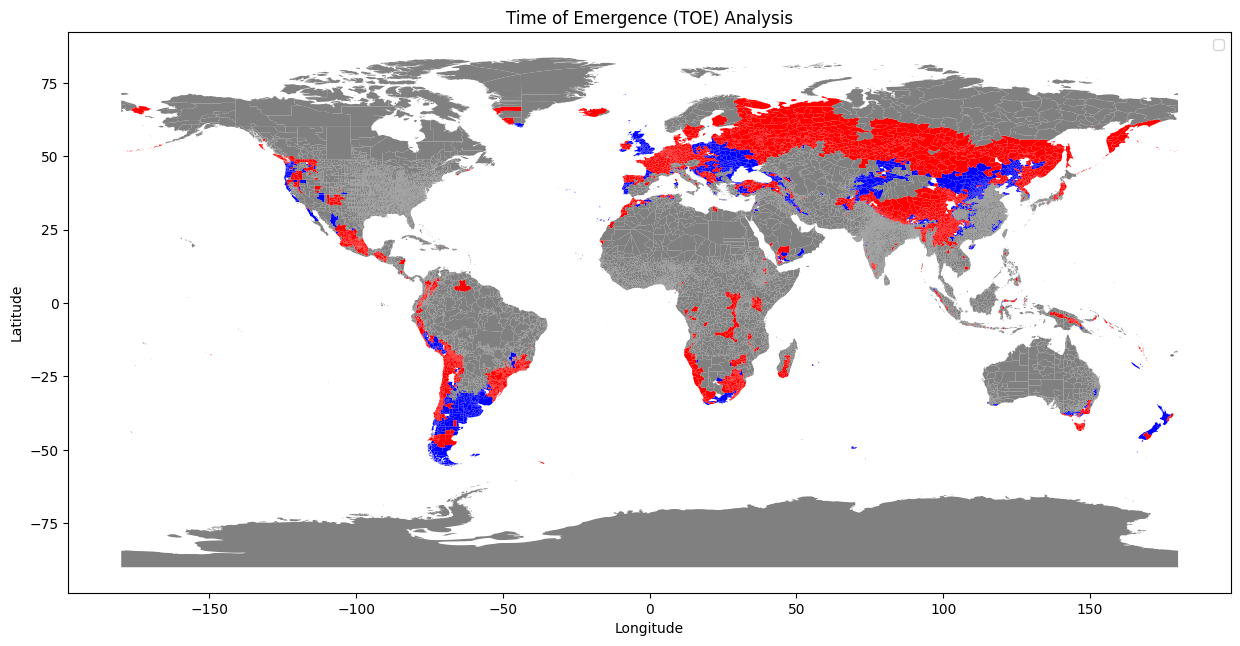

In [57]:
TOE_Benefits_delayed_gdf = geopandas.GeoDataFrame(TOE_Benefits_delayed_df, geometry='geometry')
TOE_Benefits_accelerated_gdf = geopandas.GeoDataFrame(TOE_Benefits_accelerated_df, geometry='geometry')
no_Benefits_emergence_gdf = geopandas.GeoDataFrame(no_Benefits_emergence_df, geometry='geometry')

# Set the coordinate reference system (CRS) if necessary
# Example: TOE_delayed_gdf.crs = "EPSG:4326"  # WGS84

# Plot the GeoDataFrames
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

TOE_Benefits_delayed_gdf.plot(ax=ax, color='blue', label='TOE Delayed')
TOE_Benefits_accelerated_gdf.plot(ax=ax, color='red', label='TOE Accelerated')
no_Benefits_emergence_gdf.plot(ax=ax, color='gray', label='No Emergence')

# Add a legend
plt.legend()

# Add titles and labels
plt.title('Time of Emergence (TOE) Analysis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


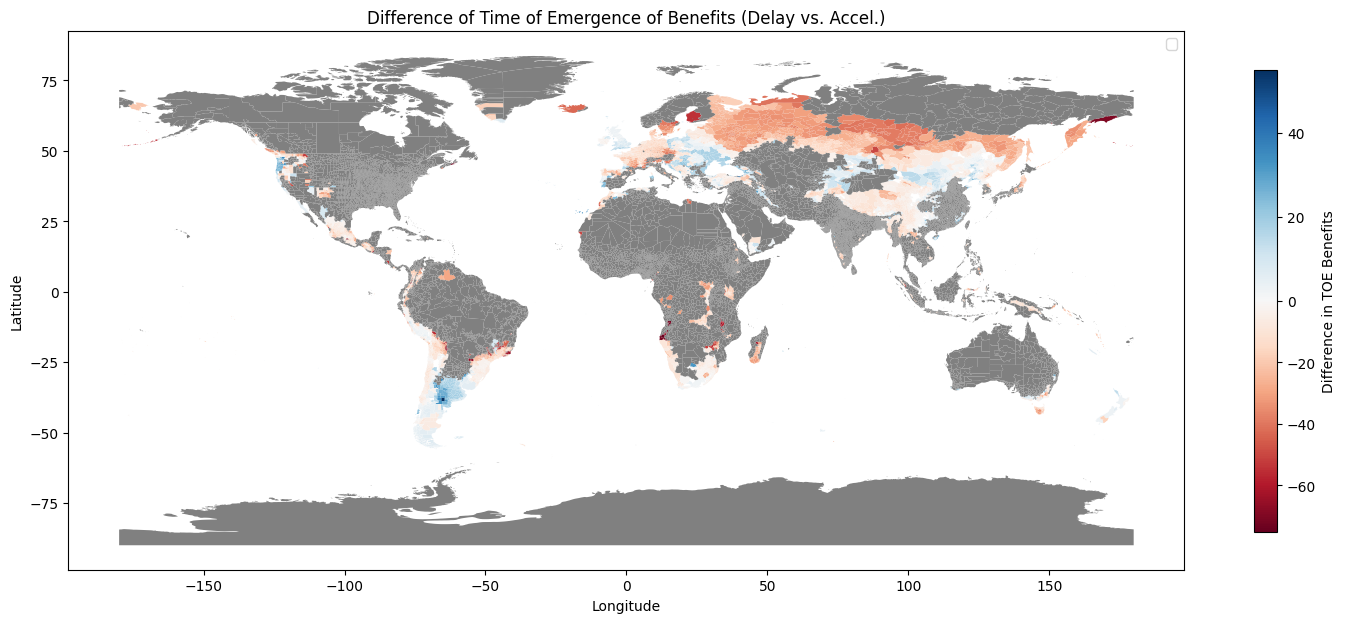

In [58]:
# Convert to GeoDataFrames
TOE_Benefits_delayed_gdf = geopandas.GeoDataFrame(TOE_delayed_df, geometry='geometry')
TOE_Benefits_accelerated_gdf = geopandas.GeoDataFrame(TOE_accelerated_df, geometry='geometry')
no_emergence_gdf = geopandas.GeoDataFrame(no_emergence_df, geometry='geometry')

# Combine all data for consistent color mapping
combined_Benefits_gdf = geopandas.GeoDataFrame(pd.concat([TOE_Benefits_delayed_gdf, TOE_Benefits_accelerated_gdf], ignore_index=True), geometry='geometry')

# Create a colormap and norm centered on 0
cmap = plt.get_cmap('RdBu')  # Diverging colormap from blue to red
norm = TwoSlopeNorm(vmin=combined_Benefits_gdf['TOE_Benefits_Diff'].min(), vcenter=0, vmax=combined_gdf['TOE_Benefits_Diff'].max())

# Plot the GeoDataFrames
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

# Plot the regions with colormap
combined_Benefits_gdf.plot(ax=ax, column='TOE_Benefits_Diff', cmap=cmap, norm=norm, legend=True, legend_kwds={'shrink': 0.5, 'label': "Difference in TOE Benefits"})

# Plot no emergence regions in gray
no_Benefits_emergence_gdf.plot(ax=ax, color='gray')

# Add a legend
plt.legend()

# Add titles and labels
plt.title('Difference of Time of Emergence of Benefits (Delay vs. Accel.)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [59]:
print(combined_Benefits_gdf['TOE_Benefits_Diff'].min(), combined_Benefits_gdf['TOE_Benefits_Diff'].max())

-75.0 55.0


## Acceleration and Delay of Emergence of Damages:

In [51]:
TOE_Damages_diff = TOE_sf_24k_merged['TOE_Damages'] - histclim_TOE_sf_24k_merged['TOE_Damages']

# Create the new DataFrame 'A' with the retained columns and the calculated differences
TOE_Damages_diff_df = TOE_sf_24k_merged[['gadmid', 'region', 'ISO', 'geometry']].copy()
TOE_Damages_diff_df['TOE_Damages_Diff'] = TOE_Damages_diff

TOE_Damages_diff_df


,gadmid,region,ISO,geometry,TOE_Damages_Diff
0,28115,CAN.1.2.28,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN
1,28116,CAN.1.17.403,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN
2,28119,CAN.2.34.951,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN
3,28120,CAN.11.259.4274,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN
...,...,...,...,...,...
24373,6905,BWA.1,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN
24374,6902,BWA.7,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN
24375,6915,BWA.6.16,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN
24376,6909,BWA.5,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN


In [72]:
TOE_Damages_delayed = []
TOE_Damages_accelerated = []
no_Damages_emergence = []

# Iterate through the DataFrame and append to the appropriate list
for index, row in TOE_Damages_diff_df.iterrows():
    if pd.isna(row['TOE_Damages_Diff']):
        no_Damages_emergence.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Damages_Diff']])
    elif row['TOE_Damages_Diff'] > 0:
        TOE_Damages_delayed.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Damages_Diff']])
    elif row['TOE_Damages_Diff'] < 0:
        TOE_Damages_accelerated.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Damages_Diff']])

# Convert lists to DataFrames for easier manipulation if needed
TOE_Damages_delayed_df = pd.DataFrame(TOE_Damages_delayed)
TOE_Damages_accelerated_df = pd.DataFrame(TOE_Damages_accelerated)
no_Damages_emergence_df = pd.DataFrame(no_Damages_emergence)

## Acceleration of Climate Damages

The dataset `TOE_Damages_accelerated_df` contains information about regions where the time of emergence (ToE) for climate damages is accelerated. This means that the conditions for climate damages happen sooner in the given timeframe or under the specified scenarios. 

---

In [73]:
TOE_Damages_accelerated_df

,gadmid,region,ISO,geometry,TOE_Damages_Diff
12951,205147,USA.15.770,USA,"POLYGON ((-86.7934112548827 38.20700073242193,...",-2.0
13015,205211,USA.47.2874,USA,POLYGON ((-78.06307220458979 37.90560913085937...,-6.0
13016,205212,USA.26.1565,USA,POLYGON ((-89.67381286621094 37.80270004272461...,-3.0
13065,205261,USA.47.2843,USA,"POLYGON ((-79.0227661132812 37.43173217773449,...",-5.0
13200,205396,USA.34.1978,USA,POLYGON ((-80.02954101562494 36.54286193847662...,-3.0
18054,3529,AUS.11.1392,AUS,MULTIPOLYGON (((128.99969482421886 -15.0663280...,-32.0
18068,3545,AUS.6.846,AUS,POLYGON ((151.6476287841797 -26.91317558288568...,-2.0
18166,3692,AUS.6.547,AUS,POLYGON ((151.2728729248047 -27.14551925659179...,-3.0
18238,3779,AUS.6.706,AUS,POLYGON ((139.5066833496096 -19.44231986999511...,-1.0
18317,3870,AUS.6.713,AUS,POLYGON ((151.3306884765625 -25.39475631713867...,-7.0


## Delayed Emergence of Climate Damages

The dataset `TOE_Damages_delayed_df` contains information about regions where the time of emergence (ToE) for climate damages is delayed. This indicates that the damages are expected to occur later than initially projected or observed under historical scenarios.


In [74]:
TOE_Damages_delayed_df

,gadmid,region,ISO,geometry,TOE_Damages_Diff
2225,97092,JPN.29.1229,JPN,POLYGON ((139.24362182617188 37.97145843505865...,53.0
2236,97345,JPN.41.1627,JPN,"POLYGON ((139.33528137207043 35.7072372436524,...",39.0
2241,97450,JPN.39.1588,JPN,POLYGON ((140.00477600097656 36.50189590454101...,53.0
2290,98252,JPN.41.1646,JPN,POLYGON ((139.45718383789062 35.61264038085943...,28.0
2300,98557,JPN.11.436,JPN,POLYGON ((132.51004028320312 34.38249588012701...,20.0
...,...,...,...,...,...
13432,205628,USA.11.523,USA,POLYGON ((-83.54981231689453 34.99288940429687...,38.0
18233,3774,AUS.5.335,AUS,POLYGON ((130.83868408203125 -17.4562282562255...,32.0
18244,3785,AUS.6.527,AUS,POLYGON ((140.92247009277344 -19.1349182128906...,3.0
18397,4078,AUS.6.844,AUS,POLYGON ((150.70370483398438 -27.9343242645263...,1.0


## No Emergence of Climate Benefits

The dataset `no_emergence_df` contains information about regions where the time of emergence (ToE) for climate benefits does not occur based on the analysis. This means that the conditions for climate benefits are not met in the given timeframe or under the specified scenarios. 

---

In [75]:
no_Damages_emergence_df

,gadmid,region,ISO,geometry,TOE_Damages_Diff
0,28115,CAN.1.2.28,CAN,POLYGON ((-110.0545883178711 53.30730056762695...,NaN
1,28116,CAN.1.17.403,CAN,POLYGON ((-111.23054504394526 52.9194259643554...,NaN
2,28119,CAN.2.34.951,CAN,POLYGON ((-127.68527221679688 55.2957000732422...,NaN
3,28120,CAN.11.259.4274,CAN,POLYGON ((-77.73079681396479 55.31879043579118...,NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.2593994140625 54.99974822998058,...",NaN
...,...,...,...,...,...
24373,6905,BWA.1,BWA,POLYGON ((26.01722908020031 -23.55864906311023...,NaN
24374,6902,BWA.7,BWA,POLYGON ((22.50413322448736 -18.11382102966303...,NaN
24375,6915,BWA.6.16,BWA,POLYGON ((27.28497123718273 -20.49781227111810...,NaN
24376,6909,BWA.5,BWA,POLYGON ((23.05666923522955 -23.31138992309564...,NaN


In [36]:
#2050
gdp_2050 = ds_econ['gdp'].sel(year = 2050).to_dataframe().reset_index()
gdp_2090 = ds_econ['gdp'].sel(year = 2090).to_dataframe().reset_index()

pop65plus_2050 = ds_econ['pop65plus'].sel(year = 2050).to_dataframe().reset_index()
pop65plus_2090 = ds_econ['pop65plus'].sel(year = 2090).to_dataframe().reset_index()

gdppc_2050 = ds_econ['gdppc'].sel(year = 2050).to_dataframe().reset_index()
gdppc_2090 = ds_econ['gdppc'].sel(year = 2090).to_dataframe().reset_index()

pop0to4_2050 = ds_econ['pop0to4'].sel(year = 2050).to_dataframe().reset_index()
pop0to4_2090 = ds_econ['pop0to4'].sel(year = 2090).to_dataframe().reset_index()

pop_2050 = ds_econ['pop'].sel(year = 2050).to_dataframe().reset_index()
pop_2090 = ds_econ['pop'].sel(year = 2090).to_dataframe().reset_index()

pop5to64_2050 = ds_econ['pop5to64'].sel(year = 2050).to_dataframe().reset_index()
pop5to64_2090 = ds_econ['pop5to64'].sel(year = 2090).to_dataframe().reset_index()

sf_24k = sf_24k.sort_values("region")


In [37]:
gdp_merged = gdp_2050.merge(gdp_2090, on = 'region')
gdppc_merged = gdppc_2050.merge(gdppc_2090, on = 'region')

pop65plus_merged = pop65plus_2050.merge(pop65plus_2090, on = 'region')
pop0to4_merged = pop0to4_2050.merge(pop0to4_2090, on = 'region')

pop_merged = pop_2050.merge(pop_2090, on = 'region')
pop5to64_merged = pop5to64_2050.merge(pop5to64_2090, on = 'region')


In [113]:
gdp_sf_24k_merged = sf_24k.merge(gdp_merged, on='region').drop(columns = {'model_x', 'ssp_x'})
gdp_sf_24k_merged = gdp_sf_24k_merged.rename(columns = {'model_y': 'iam', 'ssp_y' : 'SSP', 'gdp_x' : 'GDP_2050', 'gdp_y': 'GDP_2090'})

gdppc_sf_24k_merged = sf_24k.merge(gdppc_merged, on='region').drop(columns = {'model_x', 'ssp_x'})
gdppc_sf_24k_merged = gdppc_sf_24k_merged.rename(columns = {'model_y': 'iam', 'ssp_y' : 'SSP', 'gdppc_x' : 'GDPPC_2050', 'gdppc_y': 'GDPPC_2090'})

pop65plus_sf_24k_merged = sf_24k.merge(pop65plus_merged, on='region').drop(columns = {'model_x', 'ssp_x'})
pop65plus_sf_24k_merged = pop65plus_sf_24k_merged.rename(columns = {'model_y': 'iam', 'ssp_y' : 'SSP', 'pop65plus_x' : 'Pop65Plus_2050', 'pop65plus_y': 'Pop65Plus_2090'})

pop0to4_sf_24k_merged = sf_24k.merge(pop0to4_merged, on='region').drop(columns = {'model_x', 'ssp_x'})
pop0to4_sf_24k_merged = pop0to4_sf_24k_merged.rename(columns = {'model_y': 'iam', 'ssp_y' : 'SSP', 'pop0to4_x' : 'Pop0to4_2050', 'pop0to4_y': 'Pop0to4_2090'})

pop_sf_24k_merged = sf_24k.merge(pop_merged, on='region').drop(columns = {'model_x', 'ssp_x'})
pop_sf_24k_merged = pop_sf_24k_merged.rename(columns = {'model_y': 'iam', 'ssp_y' : 'SSP', 'pop_x' : 'Pop_2050', 'pop_y': 'Pop_2090'})

#pop_sf_24k_merged['Pop_2050'] = log10(pop_sf_24k_merged['Pop_2050'])
#pop_sf_24k_merged['Pop_2090'] = log10(pop_sf_24k_merged['Pop_2090'])

zero_pop_2090 = pop_sf_24k_merged[pop_sf_24k_merged['region'] == 0]

zero_pop_2090


,gadmid,region,color,ISO,geometry,year_x,Pop_2050,iam,SSP,year_y,Pop_2090


## TOE of Benefits and Damages Global Map:

Text(0.5, 1.0, 'Time of Emergence (ToE) of Damages - CCSM4/SSP3/RCP8.5/iamlow')

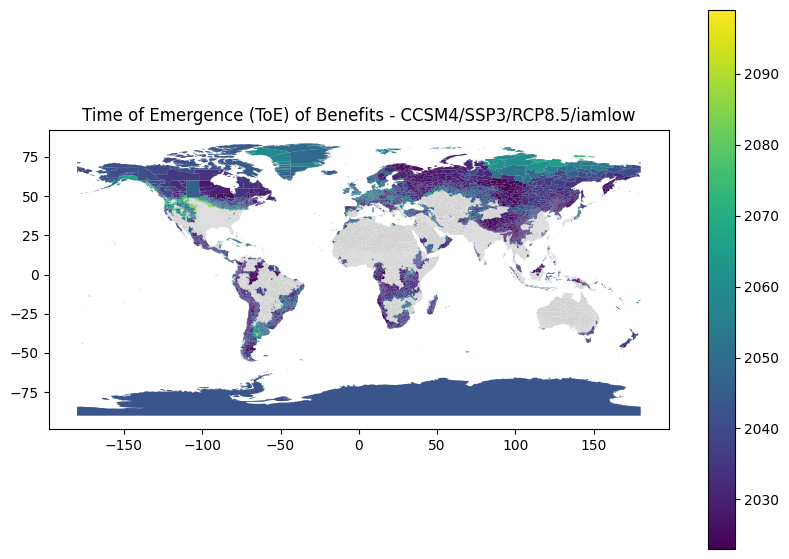

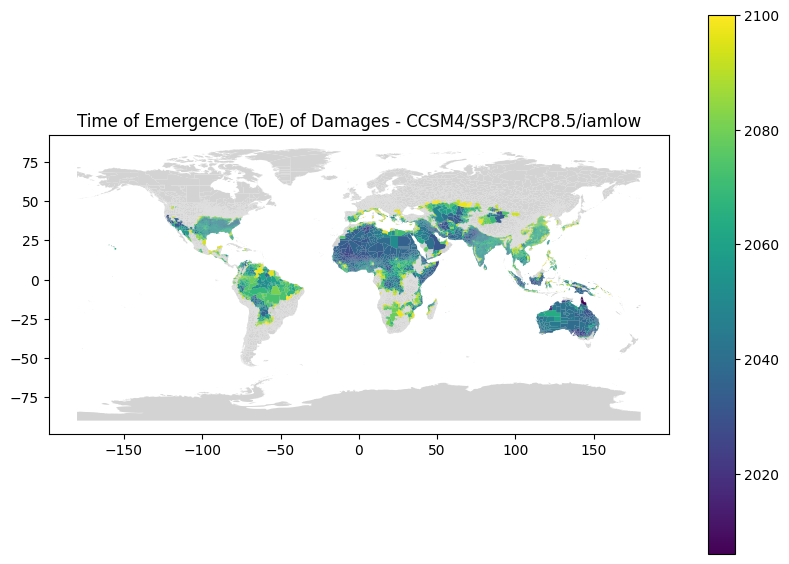

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 7))
TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax1)
TOE_sf_24k_merged.plot(column='TOE_Benefits', cmap='viridis', legend=True, ax=ax1)
ax1.set_title("Time of Emergence (ToE) of Benefits - CCSM4/SSP3/RCP8.5/iamlow")

fig, ax2 = plt.subplots(figsize=(10, 7))
TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax2)
TOE_sf_24k_merged.plot(column='TOE_Damages', cmap='viridis', legend=True, ax=ax2)
ax2.set_title("Time of Emergence (ToE) of Damages - CCSM4/SSP3/RCP8.5/iamlow")


## TOE of Benefits and Damages Historical Climate Global Map

Text(0.5, 1.0, 'Time of Emergence (ToE) of Damages - Historical Climate - CCSM4/SSP3/RCP8.5/iamlow')

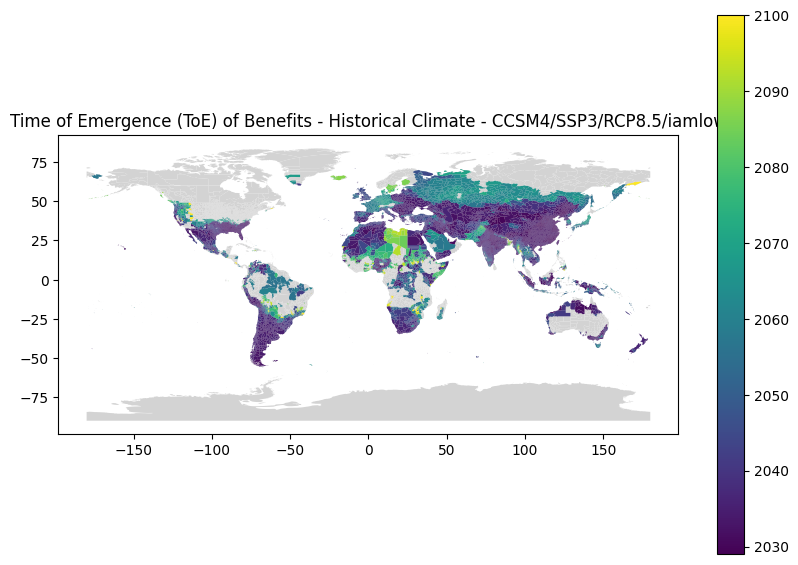

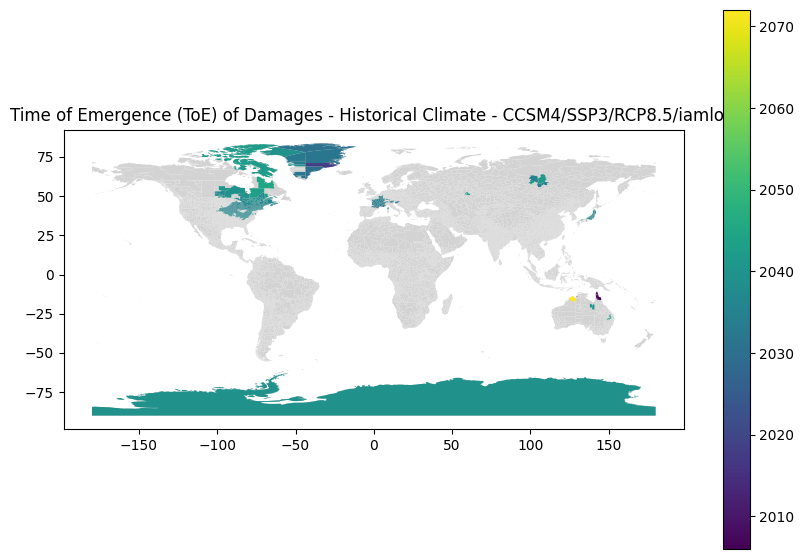

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 7))
histclim_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax1)
histclim_TOE_sf_24k_merged.plot(column='TOE_Benefits', cmap='viridis', legend=True, ax=ax1)
ax1.set_title("Time of Emergence (ToE) of Benefits - Historical Climate - CCSM4/SSP3/RCP8.5/iamlow")

fig, ax2 = plt.subplots(figsize=(10, 7))
histclim_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax2)
histclim_TOE_sf_24k_merged.plot(column='TOE_Damages', cmap='viridis', legend=True, ax=ax2)
ax2.set_title("Time of Emergence (ToE) of Damages - Historical Climate - CCSM4/SSP3/RCP8.5/iamlow")


## TOE of Benefits and Damages Difference (Full Adaptation - Historical Climate) Global Maps:

Text(0.5, 1.0, 'Time of Emergence (ToE) of Damages - Simple Difference w/ Historical Climate - CCSM4/SSP3/RCP8.5/iamlow')

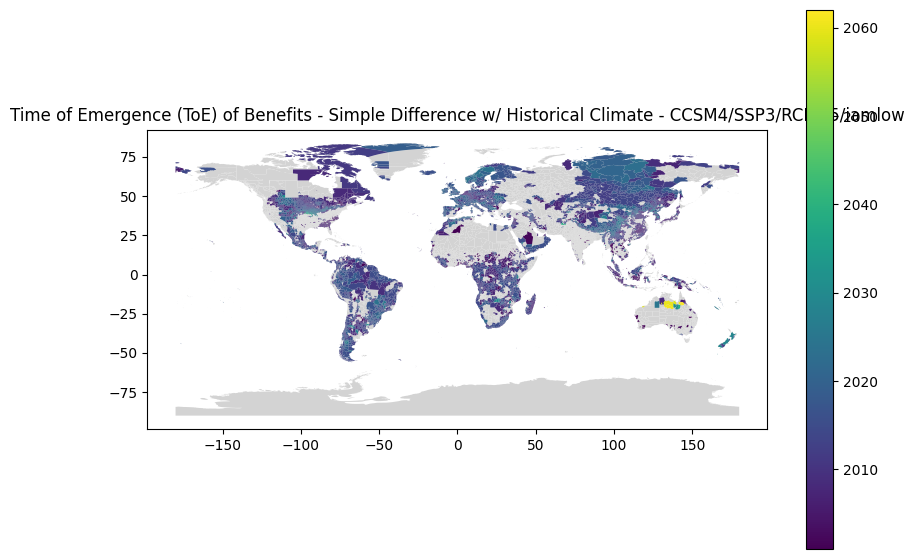

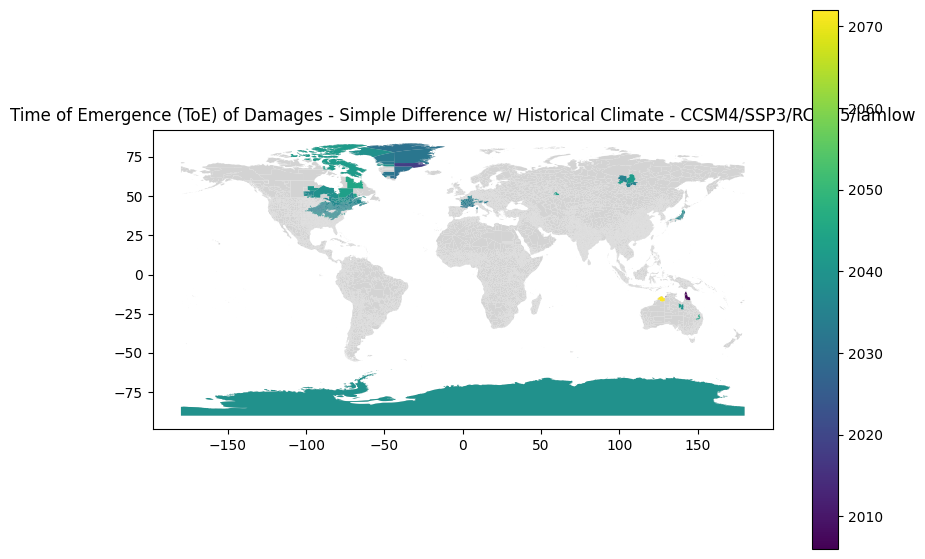

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 7))
simple_difference_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax1)
simple_difference_TOE_sf_24k_merged.plot(column='TOE_Benefits', cmap='viridis', legend=True, ax=ax1)
ax1.set_title("Time of Emergence (ToE) of Benefits - Simple Difference w/ Historical Climate - CCSM4/SSP3/RCP8.5/iamlow")

fig, ax2 = plt.subplots(figsize=(10, 7))
histclim_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax2)
histclim_TOE_sf_24k_merged.plot(column='TOE_Damages', cmap='viridis', legend=True, ax=ax2)
ax2.set_title("Time of Emergence (ToE) of Damages - Simple Difference w/ Historical Climate - CCSM4/SSP3/RCP8.5/iamlow")


/home/dtb96/.conda/envs/myenv1/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dtb96/.conda/envs/myenv1/lib/python3.9/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dtb96/.conda/envs/myenv1/lib/python3.9/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/home/dtb96/.conda/envs/myenv1/lib/python3.9/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dtb96/.conda/envs/myenv1/lib/python3.9/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


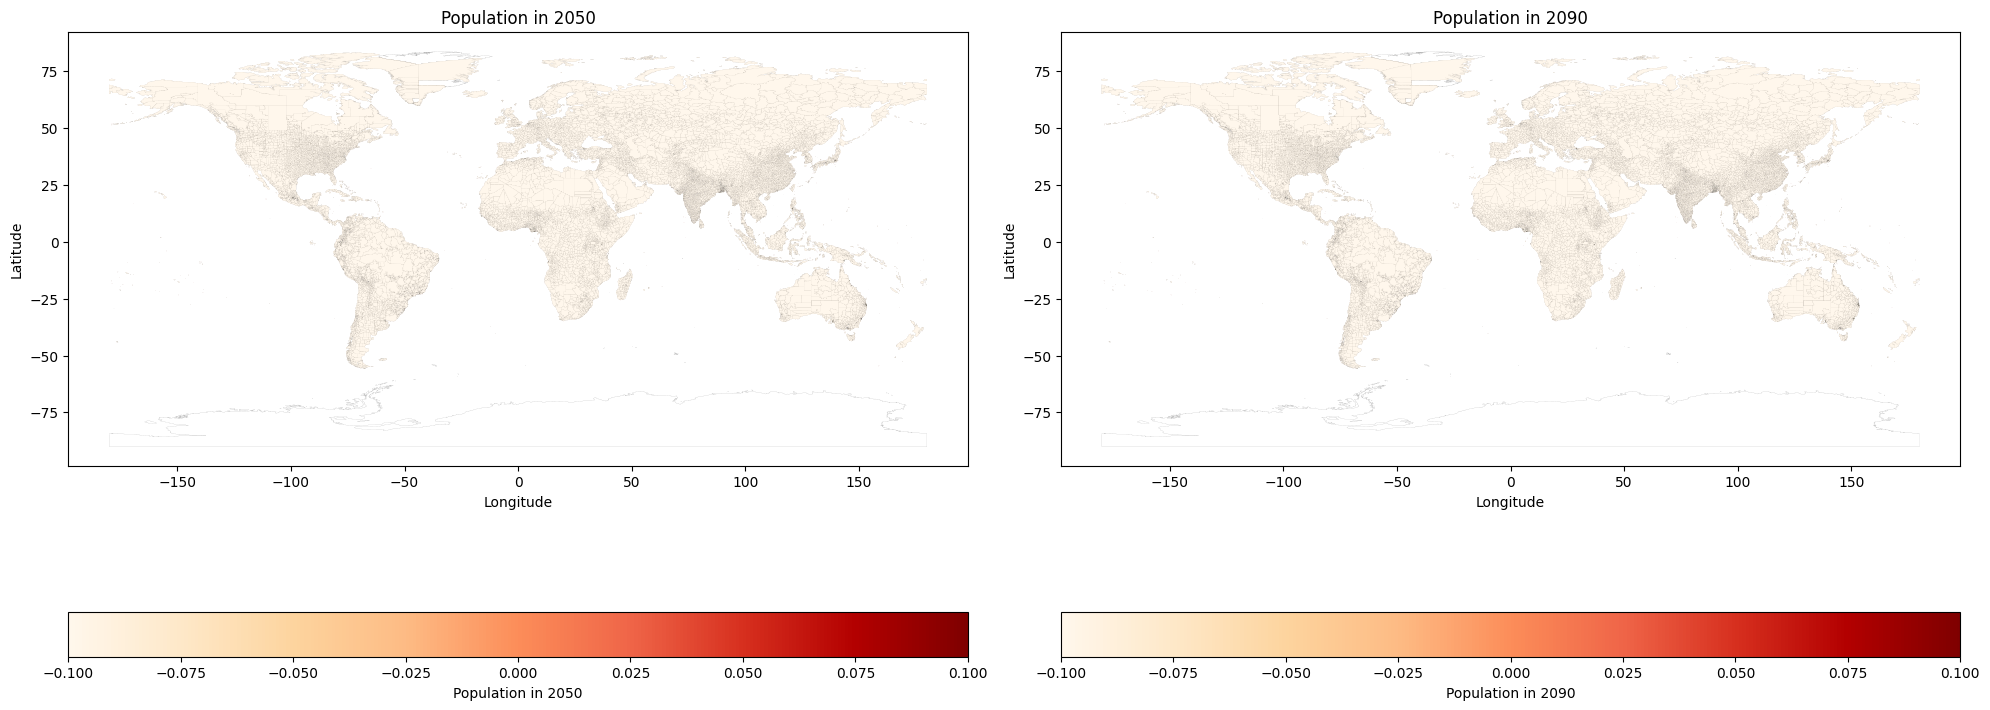

In [114]:
pop_sf_24k_merged['Pop_2050'] = log10(pop_sf_24k_merged['Pop_2050'])
pop_sf_24k_merged['Pop_2090'] = log10(pop_sf_24k_merged['Pop_2090'])
# Create figures for the two population years
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot Population 2050
pop_sf_24k_merged.plot(column='Pop_2050', ax=ax[0], legend=True,
                      cmap='OrRd', linewidth=0.01, edgecolor='black',
                      legend_kwds={'label': "Population in 2050",
                                   'orientation': "horizontal"})

ax[0].set_title('Population in 2050')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot Population 2090
pop_sf_24k_merged.plot(column='Pop_2090', ax=ax[1], legend=True,
                      cmap='OrRd', linewidth=0.01, edgecolor='black',
                      legend_kwds={'label': "Population in 2090",
                                   'orientation': "horizontal"})

ax[1].set_title('Population in 2090')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


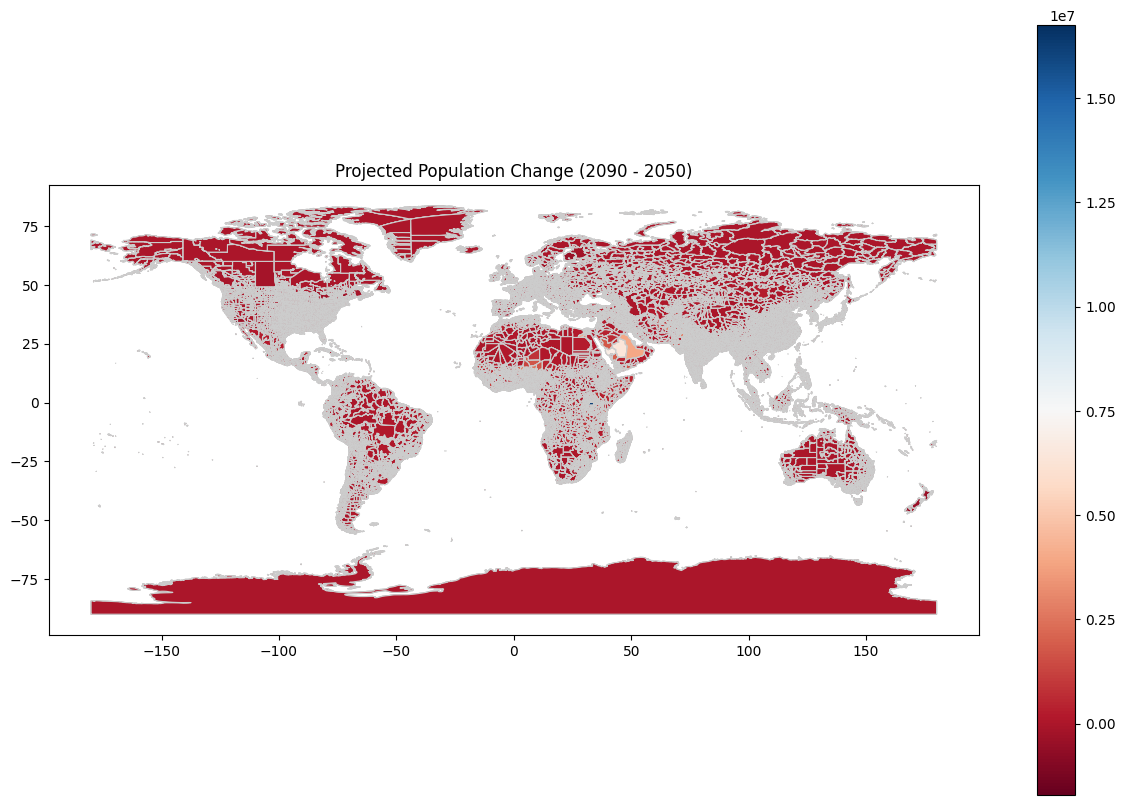

In [88]:
pop_sf_24k_merged['Pop_Change'] = pop_sf_24k_merged['Pop_2090'] - pop_sf_24k_merged['Pop_2050']

# Plotting the population change
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

pop_sf_24k_merged.plot(column='Pop_Change', ax=ax, legend=True, cmap='RdBu', linewidth=0.8, edgecolor='0.8')

# Add a title
plt.title('Projected Population Change (2090 - 2050)')

# Show the plot
plt.show()

In [ ]:
#create function that applies to single region, and produces year and categorizations
#loop over each region and contextualize, core function should focus on one times series, then can accumulate the rest of the regions
#apply this function to every region - split the functions up (relative to historical period)
#def categorize_intersections(rebased_qs):
    #categories = {
        #"Climate Change Accelerates Emergence of Development Benefits": [],
        #"Climate Change Leads to Emergence of Benefits": [],
        #"Climate Change Delays Emergence of Development Benefits": [],
        #"Climate Change Leads to Emergence of Harms": [],
        #"Climate Change leads to emergence of benefits": [],
        #"Places where there are two quantile crossings": []

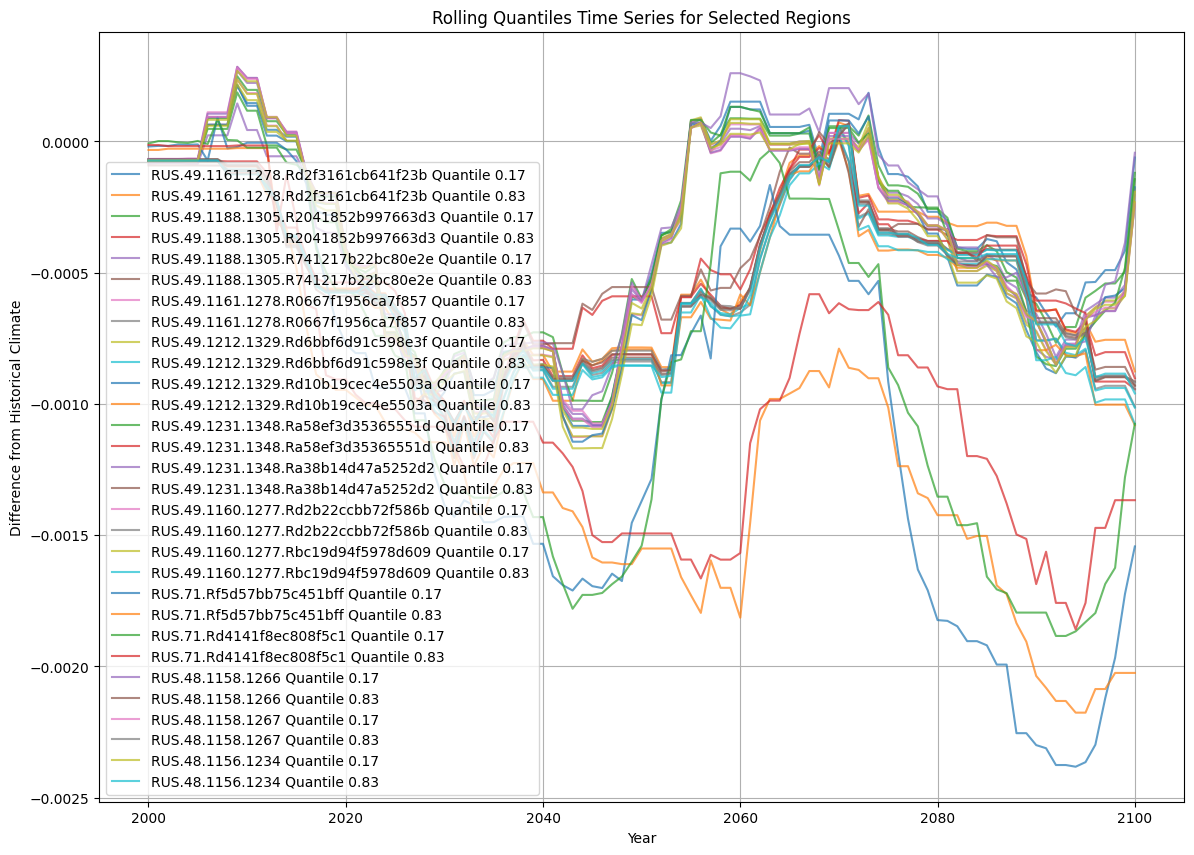

In [115]:
import xarray as xr
import matplotlib.pyplot as plt

# Define user input region codes
user_region_codes = ['AUS', 'RUS']  # Add more codes as needed

# Filter dataset for the given regions
filtered_ds = ds.sel(region=[code for code in ds.region.values if any(code.startswith(region) for region in user_region_codes)])

# Calculate rolling quantiles for filtered data
rolling_quantiles = filtered_ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")
histclim_rolling_quantiles = ds_histclim["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")

# Compute the difference
simple_difference_rolling_quantiles = rolling_quantiles - histclim_rolling_quantiles

# Define number of regions to plot
num_regions_to_plot = 15

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(14, 10))

# Get the first `num_regions_to_plot` regions for plotting
for region_code in filtered_ds.region.values[:num_regions_to_plot]:
    region_data = simple_difference_rolling_quantiles.sel(region=region_code)
    
    # Plotting each quantile
    for quantile in [quantile_low, quantile_high]:
        ax.plot(region_data['year'], region_data.sel(quantile=quantile), label=f'{region_code} Quantile {quantile}', alpha=0.7)

# Plot mean and median if required
# For example: ax.plot(...) 

# Customize plot
ax.set_title('Rolling Quantiles Time Series for Selected Regions')
ax.set_xlabel('Year')
ax.set_ylabel('Difference from Historical Climate')
ax.legend()
ax.grid(True)

# Show plot
plt.show()
